In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '258135',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/kVOp7X5NItdLGNLUgWfl9A__thumb/img/y4kaHfBXho8z0hnpxDHDagr2lGo=/fit-in/200x150/filters:strip_icc()/pic6266685.jpg',
  'name': 'Wild Assent',
  'yearpublished': '2021'},
 {'id': '316554',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/PhjygpWSo-0labGrPBMyyg__thumb/img/JGgY-nBmkyB8WRp8vcoBLlNMQ5U=/fit-in/200x150/filters:strip_icc()/pic5666597.jpg',
  'name': 'Dune: Imperium',
  'yearpublished': '2020'}]

In [6]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,258135,Atvar,10.0,"This is a brilliant game, in both Arena and H..."
1,258135,Axelay,4.0,I am very disappointed about Coop. This is not...
2,258135,BaneStar007,N/A,Waiting to Arrive
3,258135,batman14,5.0,Played the pnp. Acitvation system and unit ori...
4,258135,Beckikaze,6.0,The skirmish module itself is good. Positionin...
...,...,...,...,...
95548,167791,z_zadar,9.0,Some games are so much fun. Others can be a li...
95549,167791,_Czid_,8.0,Have played with Elysium and Prelude expansion...
95550,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
95551,167791,_mun_,10.0,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [7]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [8]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 15654 for 'remove_short_comments' - min len: 25 - method: unrated


In [9]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [10]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10.0       15983
9.0        15058
8.0        12559
7.0         6743
N/A         6618
           ...  
4.24           1
6.43333        1
8.54667        1
9.006          1
8.26667        1
Name: rating, Length: 509, dtype: int64

In [11]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(73281, 5)

In [12]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(6618, 5)

## CREATE TRAINING AND VALIDATION DATA

In [13]:
# use rated comments (reviews) to train the model

In [14]:
rated_comments = rated_comments.sample(frac=1)

In [15]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [16]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Sleeved: All Cards 63.5x88 (Standard) Game Cards - 142 - FFS05  BGG Sleeve Link:  '

In [17]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'There\'s some really good stuff here, all of which come with a "but...".  I like the mashup of worker placement and deck building, but limiting the available worker placement spots with the cards in your hand creates a situation where the two mechanisms are at odds with each other instead of enhancing each other. You are either blocked from some spots that you need because you had a bad draw, or you have to focus on building a deck of symbol variety and put less thought into the actual card effects and your deck engine.  Having the Signet Ring symbol trigger your asymmetric special ability is a cool idea, but there\'s no way to get more Signet Ring symbols into your deck, so your special ability becomes less and less powerful as you build your deck. And since every special ability isn\'t created equal, luck of the draw can make some special abilities feel very over powered.  I like the idea of the conflict round, but aside from the sword icon on some cards, conflict has no thematic fe

## COMPOSE MODEL

In [18]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [19]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
36/36 - 4s - loss: 0.6258 - accuracy: 0.6769 - val_loss: 0.5277 - val_accuracy: 0.8457
Epoch 2/100
36/36 - 2s - loss: 0.4879 - accuracy: 0.8498 - val_loss: 0.4469 - val_accuracy: 0.8552
Epoch 3/100
36/36 - 2s - loss: 0.4039 - accuracy: 0.8549 - val_loss: 0.3779 - val_accuracy: 0.8598
Epoch 4/100
36/36 - 2s - loss: 0.3369 - accuracy: 0.8702 - val_loss: 0.3389 - val_accuracy: 0.8686
Epoch 5/100
36/36 - 2s - loss: 0.2917 - accuracy: 0.8871 - val_loss: 0.3198 - val_accuracy: 0.8742
Epoch 6/100
36/36 - 2s - loss: 0.2585 - accuracy: 0.8998 - val_loss: 0.3112 - val_accuracy: 0.8769
Epoch 7/100
36/36 - 2s - loss: 0.2313 - accuracy: 0.9114 - val_loss: 0.3099 - val_accuracy: 0.8787
Epoch 8/100
36/36 - 2s - loss: 0.2085 - accuracy: 0.9212 - val_loss: 0.3125 - val_accuracy: 0.8784
Epoch 9/100
36/36 - 2s - loss: 0.1893 - accuracy: 0.9300 - val_loss: 0.3196 - val_accuracy: 0.8764
Epoch 10/100
36/36 - 2s - loss: 0.1728 - accuracy: 0.9377 - val_loss: 0.3311 - val_accuracy: 0.8748
Epoch 11/

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002620F44C160>,
             param_grid={})

In [20]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [21]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [23]:
epochs = range(1, len(acc) + 1) 

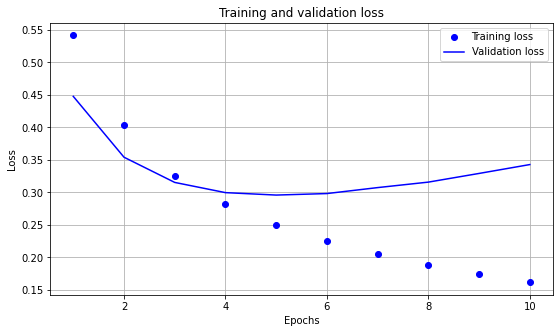

In [24]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

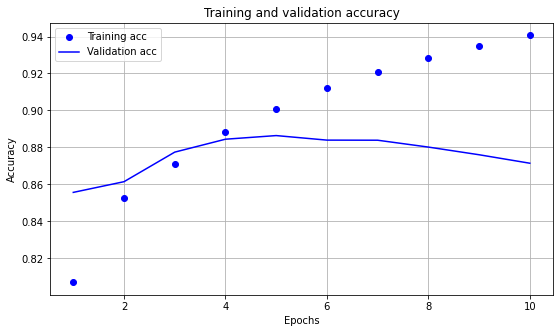

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [26]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Sleeved: All Cards 63.5x88 (Standard) Game Cards - 142 - FFS05  BGG Sleeve Link:  "
score: 1.000000
actual: 1

input:
"One of the best mechanisms to reduce the impact luck in any eurogame out there."
score: 1.000000
actual: 1

input:
"2020年我的个人最佳"
score: 0.000000
actual: 1

input:
"There's some really good stuff here, all of which come with a "but...".  I like the mashup of worker placement and deck building, but limiting the available worker placement spots with the cards in your hand creates a situation where the two mechanisms are at odds with each other instead of enhancing each other. You are either blocked from some spots that you need because you had a bad draw, or you have to focus on building a deck of symbol variety and put less thought into the actual card effects and your deck engine.  Having the Signet Ring symbol trigger your asymmetric special ability is a cool idea, but there's no way to get more Signet Ring symbols into your deck, so your special ability become

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [27]:
## APPLY MODEL ON NON-RATED COMMENTS

In [28]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

7/7 - 0s
input:
"Currently with Russ. No plays throughs have been completed."
score: 1.000000

input:
"Living Room. Third Cupboard. Fourth Shelf. Outside   "
score: 1.000000

input:
"Thematic  Comparison: • Star Wars: Rebellion • Twilight Struggle • Lord of the Rings • Middle-earth • Lord of the Rings: The Confrontation"
score: 1.000000

input:
"Semi-cooperative survival sci-fi game. Wake up on a space ship, like the movie Alien. Hard to find, can only really buy as a late pledge on kickstarter. $120 9/20/20"
score: 1.000000

input:
"Idioma: Castellano. Estado Caja: Bien salvo esquinas. Estado Material: Perfecto, falta 1 Nazgul de 8 Enfundado: SI (Estandard) PVP: 75€ (72€ +3€ Fundas Swan Standard) Coste: 17.5€ Ahorrado: 57.5€"
score: 1.000000

input:
"1-4 p, complex, nice fairy-like theme with animals, 40-80 min"
score: 1.000000

input:
"These impressions are based off a finished campaign. Gloomhaven is a colossal box and campaign that is awe-inspiring at first, but may become exhausti

## REGRESSOR

In [29]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x00000264D5927D60>,
             param_grid={})

In [30]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [31]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [32]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [33]:
epochs = range(1, len(mean_squared_error) + 1) 

In [34]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.55


In [35]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 0.99


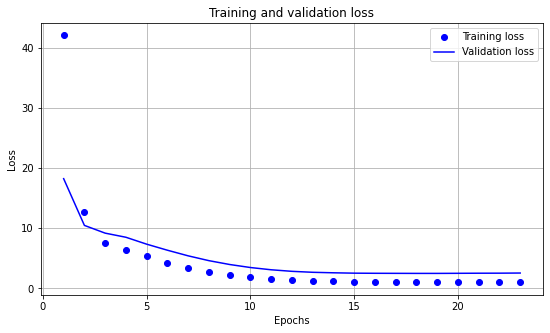

In [36]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

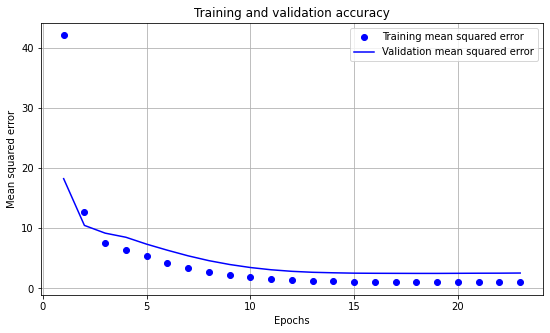

In [37]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [38]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Sleeved: All Cards 63.5x88 (Standard) Game Cards - 142 - FFS05  BGG Sleeve Link:  "
score: 7.65
actual: 8.50 

input: 
"One of the best mechanisms to reduce the impact luck in any eurogame out there."
score: 7.90
actual: 10.00 

input: 
"2020年我的个人最佳"
score: 7.42
actual: 10.00 

input: 
"There's some really good stuff here, all of which come with a "but...".  I like the mashup of worker placement and deck building, but limiting the available worker placement spots with the cards in your hand creates a situation where the two mechanisms are at odds with each other instead of enhancing each other. You are either blocked from some spots that you need because you had a bad draw, or you have to focus on building a deck of symbol variety and put less thought into the actual card effects and your deck engine.  Having the Signet Ring symbol trigger your asymmetric special ability is a cool idea, but there's no way to get more Signet Ring symbols into your deck, so your special ability 

## COMPARE CLASSIFIER VS REGRESSOR

In [39]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Best with 3to4 Zee says best with 2 21-69-10  W2.92......R8.1"
    reg score: 9.07
    clf score: 1

"-"Gozuzone" 3D printed insert -From a kind Santa in the 2017 BGG exchange :)"
    reg score: 6.11
    clf score: 1

"Here because it sounds like Gloomhaven-lite, but not sure about constant battles."
    reg score: 6.29
    clf score: 0

"+ Too Many Bones: Undertow + Too Many Bones: Tink (2017) + Too Many Bones: Nugget (2017) + Too Many Bones: Gasket (2018) + Too Many Bones: Ghillie (2017) + Too Many Bones: 40 Days in Daelore + Too Many Bones: Age of Tyranny + Too Many Bones: Premium Health + Too Many Bones: Adventure Map 2.0 + Too Many Bones: Ally Pack"
    reg score: 10.04
    clf score: 0

"Curious what all the hype is about. Would love to play sometime"
    reg score: 8.03
    clf score: 1

"Lmk how much you want, maybe we can work a price?"
    reg score: 7.85
    clf score: 1

"1-6 Players // Best 3 // 40-80 min // All Expansions"
    reg score: 9.01
    clf score: 1

"Kickstart

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [40]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 115746.00 |          8.73 |        1921.00 |
| 162886.00 |          8.36 |        3610.00 |
| 167355.00 |          8.41 |        1920.00 |
| 167791.00 |          8.20 |        8397.00 |
| 169427.00 |          8.64 |         265.00 |


In [41]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [42]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|        id |   rating_mean |   rating_count |
|-----------|---------------|----------------|
| 115746.00 |          8.30 |         271.00 |
| 162886.00 |          8.15 |         321.00 |
| 167355.00 |          8.25 |         211.00 |
| 167791.00 |          8.18 |         446.00 |
| 169427.00 |          8.59 |          74.00 |


In [43]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [44]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/kVOp7X5...","<a href=""https://boardgamegeek.com/boardgame/2...",6.000000,7.733252,6.239069,1,2021
1,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.080258,7.800599,8.056977,2,2020
2,"<img src=""https://cf.geekdo-images.com/YWHB6f-...","<a href=""https://boardgamegeek.com/boardgame/3...",NaN,7.215622,NaN,3,2021
3,"<img src=""https://cf.geekdo-images.com/gTxav_K...","<a href=""https://boardgamegeek.com/boardgame/2...",7.760125,8.252514,7.886908,4,2021
4,"<img src=""https://cf.geekdo-images.com/NPWdxDD...","<a href=""https://boardgamegeek.com/boardgame/3...",8.192258,7.361513,7.909451,5,2020


In [45]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [46]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Wild Assent,6.000000,7.733252,6.239069,1,2021
2,,Dune: Imperium,8.080258,7.800599,8.056977,2,2020
3,,Dune: Imperium – Rise of Ix,NaN,7.215622,NaN,3,2021
4,,Oath: Chronicles of Empire and Exile,7.760125,8.252514,7.886908,4,2021
5,,The LOOP,8.192258,7.361513,7.909451,5,2020


In [47]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Gloomholdin',9.500000,8.178806,9.059602,30,2021
2,,Chronicles of Drunagor: Age of Darkness,9.010495,8.919979,9.002340,32,2021
3,,Coalitions,9.000000,9.942127,9.471063,22,2022
4,,War of the Ring: Second Edition,8.729974,8.296968,8.676441,41,2012
5,,Eclipse: Second Dawn for the Galaxy,8.706171,8.217306,8.631435,33,2020


In [48]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Coalitions,9.000000,9.942127,9.471063,22,2022
2,,Gloomholdin',9.500000,8.178806,9.059602,30,2021
3,,Chronicles of Drunagor: Age of Darkness,9.010495,8.919979,9.002340,32,2021
4,,War of the Ring: Second Edition,8.729974,8.296968,8.676441,41,2012
5,,Brass: Birmingham,8.675002,8.222929,8.634590,29,2018


In [49]:
# model.save('saved_model\my_model')

In [50]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [51]:
# some examples on "long" comments vs short comments

In [52]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [53]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\"\nscore: {c['rating']:.2f}\n"), axis=1);

"Don't buy this. Engine building. Too mathematical? Dry (quoting SU&SD). Little player interaction? Bad with two. Too slow with five players. Race for the Galaxy is better as an engine builder.  Has a good solo mode though? Probably too complex for me."
score: 4.77

"2 jugadores (?). Me interesa saber si mola por si solo o si necesita expansiones. Quiero jugar antes de comprarlo. :star::star::nostar:"
score: 5.12

"Surprise gift for hubby. Received an extra Summoner in place of the Scoundrel, though, and hubby insists on waiting for the replacement mini to arrive, since that's the one I want to be playing."
score: 6.11

"Also:  Arkham Horror LCG: Blood on the Altar Mythos Pack Arkham Horror LCG: Carnevale of Horrors Arkham Horror LCG: Curse of the Rougarou... Arkham Horror LCG: The Essex County Expr... Arkham Horror LCG: Undimensioned and Unseen Arkham Horror LCG: Where Doom Awaits Mythos Pack "
score: 6.36

"Yet again does this company f*** the backers of KS project - folks that helpe

## RANDOM FOREST - TEST

In [54]:
# no support for Windows at the moment - waiting for it to test